# Classify using start=0 mid = 1 end = 2

In [1]:
import sys
import pandas as pd
import numpy as np

## 1. Read dataset

In [2]:
dirname = '../../datasets/marked_start_mid_end/'
suffix = '.csv'

def read_from_file( file_name, rand_num):
    
    try:
        full_file_name = file_name + str(rand_num)

        file_at_path = dirname + full_file_name + suffix

        data = pd.read_csv(file_at_path)
        
        return data, full_file_name
    
    except IOError as e:
        print(e)
        return None,None

## 2. Read files

### 2.1 The A series (A1-A159)

In [3]:
raw_data, full_file_name = read_from_file("A", 1)

#print(full_file_name)
print(raw_data.shape)

for i in range(2,160):
    input_data, full_file_name = read_from_file("A", i)
    
    if(full_file_name is None):
        continue
    else:
        #print(full_file_name)
        raw_data = raw_data.append(input_data, ignore_index = True)

print(raw_data.shape)

(229, 28)
[Errno 2] No such file or directory: '../../datasets/marked_start_mid_end/A60.csv'
[Errno 2] No such file or directory: '../../datasets/marked_start_mid_end/A107.csv'
(33093, 28)


### 2.2 The B series (B1-B22)

In [4]:
for i in range(1,23):
    input_data, full_file_name = read_from_file("B", i)
    
    if(full_file_name is None):
        continue
    else:
        #print(full_file_name)
        raw_data = raw_data.append(input_data, ignore_index = True)

print(raw_data.shape)

(38488, 28)


In [5]:
raw_data.fillna(0)

,FrameNo,head_x,head_y,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,...,rightHip_y,leftKnee_x,leftKnee_y,rightKnee_x,rightKnee_y,leftAnkle_x,leftAnkle_y,rightAnkle_x,rightAnkle_y,status
0,0,262.066742,994.135620,375.759686,1057.411090,382.580955,920.305207,496.493179,1079.227467,501.843892,...,932.162345,790.678961,1048.936701,799.932411,916.659549,987.035062,1052.085086,985.324309,914.177256,0
1,1,263.581139,992.800872,375.749203,1056.170479,381.573855,920.501798,496.708486,1078.117512,498.224803,...,942.356170,788.839322,1046.899053,789.020575,911.572589,987.674662,1053.617341,982.446002,913.666266,0
2,2,263.243067,993.016745,375.931049,1055.647247,381.855203,920.968293,495.078997,1078.130609,501.484271,...,942.744961,791.051172,1047.688357,785.984456,912.766431,988.034841,1054.136438,982.152660,915.409163,0
3,3,264.052307,992.361849,377.491020,1056.573054,382.514724,920.283090,496.138878,1077.009937,504.516806,...,943.913966,783.807687,1041.109386,789.262715,912.361445,987.864322,1053.845620,984.492254,916.521814,0
4,4,263.674868,992.907155,377.245414,1056.405841,382.608525,920.873450,493.847589,1076.760449,505.960956,...,942.773498,782.652318,1040.924647,788.349922,912.042381,987.438456,1053.170948,982.304178,913.830744,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38483,235,187.020227,1063.302928,268.349169,1101.640977,275.092599,980.337267,370.437723,1153.259502,378.432958,...,1004.961255,643.393000,1085.001933,636.348946,1013.502414,794.880987,1080.577164,793.098244,1003.013258,2
38484,236,186.034678,1063.276455,267.295066,1101.947708,274.296104,982.232003,368.424443,1140.413321,377.119350,...,1005.780483,638.514953,1084.204138,637.767792,1013.403677,794.218175,1079.982319,793.458130,1003.044199,2
38485,237,186.855136,1061.691429,265.131050,1100.384655,275.215525,981.939868,365.989888,1153.517583,378.954248,...,1004.996926,638.237042,1083.858278,638.585463,1013.539751,793.801283,1079.818405,793.777122,1002.993298,2
38486,238,186.557939,1058.923707,260.327946,1095.851565,273.896970,980.764162,352.193104,1139.656477,374.662521,...,1001.659971,637.281734,1083.874370,639.221573,1004.560148,793.834250,1079.758448,793.826335,1003.044853,2


In [6]:
start_0, mid_1, end_2 = np.bincount(raw_data['status'])
print(
    'Frames:\n    Total: {}\n    Before: {} ({:.2f}% of total)\n    During: {} ({:.2f}% of total)\n    After: {} ({:.2f}% of total)\n'
    .format(
      len(raw_data), 
      start_0,
      start_0 / len(raw_data),
      mid_1,
      mid_1 / len(raw_data),
      end_2,
      end_2 / len(raw_data)
    )
  )

Frames:
    Total: 38488
    Before: 8108 (0.21% of total)
    During: 23233 (0.60% of total)
    After: 7147 (0.19% of total)



In [7]:
cleaned_data = raw_data.copy()
cleaned_data.pop( 'FrameNo')

0          0
1          1
2          2
3          3
4          4
        ... 
38483    235
38484    236
38485    237
38486    238
38487    239
Name: FrameNo, Length: 38488, dtype: int64

In [8]:
# Use a utility from sklearn to split and shuffle our dataset.

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(cleaned_data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_data.pop('status'))
val_labels = np.array(val_data.pop('status'))
test_labels = np.array(test_data.pop('status'))

train_features = np.array(train_data)
val_features = np.array(val_data)
test_features = np.array(test_data)

### Normalization
Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (24632,)
Validation labels shape: (6158,)
Test labels shape: (7698,)
Training features shape: (24632, 26)
Validation features shape: (6158, 26)
Test features shape: (7698, 26)


In [10]:
import tensorflow as tf
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [12]:
def make_model(metrics=METRICS, optimizer='Adam',loss = 'categorical_crossentropy'):
    model = keras.Sequential([
        keras.layers.Dense(units=16, activation='relu',input_dim=train_features.shape[-1]),
        keras.layers.Dense(32, activation='relu' ),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    #keras.losses.BinaryCrossentropy()
    return model

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1,patience=10,mode='max',restore_best_weights=True)

In [14]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                432       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________


# Checkpoint the initial weights

In [15]:
import os
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [16]:
history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
13/13 [==============================] - 3s 75ms/step - loss: 0.0000e+00 - tp: 7649.8571 - fp: 1779.0714 - tn: 1368.7143 - fn: 4131.5000 - accuracy: 0.5000 - precision: 0.8119 - recall: 0.6904 - auc: 0.4880 - prc: 0.7588 - val_loss: 0.0000e+00 - val_tp: 2239.0000 - val_fp: 497.0000 - val_tn: 776.0000 - val_fn: 2646.0000 - val_accuracy: 0.3855 - val_precision: 0.8183 - val_recall: 0.4583 - val_auc: 0.5576 - val_prc: 0.8065
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 5073.4286 - fp: 1314.7143 - tn: 1862.8571 - fn: 6678.1429 - accuracy: 0.3672 - precision: 0.7950 - recall: 0.4397 - auc: 0.5335 - prc: 0.7947 - val_loss: 0.0000e+00 - val_tp: 1857.0000 - val_fp: 459.0000 - val_tn: 814.0000 - val_fn: 3028.0000 - val_accuracy: 0.3383 - val_precision: 0.8018 - val_recall: 0.3801 - val_auc: 0.5817 - val_prc: 0.8311
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 4424.7857 - fp: 1227.8571 - tn: 195

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [18]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  2043.0
fp :  391.0
tn :  1215.0
fn :  4049.0
accuracy :  0.3321641981601715
precision :  0.8393591046333313
recall :  0.3353578448295593
auc :  0.6137853264808655
prc :  0.8477704524993896



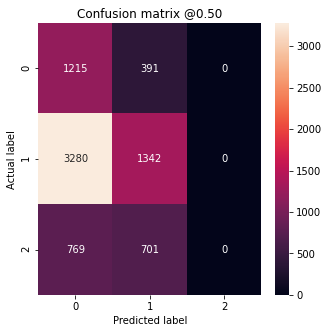

In [19]:
results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

#plot_cm(train_labels, train_predictions_baseline)

In [20]:
# Class weights

In [21]:
weight_for_0 = (1 / start_0)*(len(raw_data))/3.0 
weight_for_1 = (1 / mid_1)*(len(raw_data))/3.0
weight_for_2 = (1 / end_2)*(len(raw_data))/3.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.58
Weight for class 1: 0.55
Weight for class 2: 1.80


In [22]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
13/13 [==============================] - 2s 71ms/step - loss: 0.0000e+00 - tp: 10451.3571 - fp: 2287.8571 - tn: 2452.6429 - fn: 7435.2857 - accuracy: 0.4476 - precision: 0.8220 - recall: 0.5717 - auc: 0.5296 - prc: 0.7963 - val_loss: 0.0000e+00 - val_tp: 2573.0000 - val_fp: 543.0000 - val_tn: 730.0000 - val_fn: 2312.0000 - val_accuracy: 0.4279 - val_precision: 0.8257 - val_recall: 0.5267 - val_auc: 0.5552 - val_prc: 0.8060
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 6023.7143 - fp: 1410.5714 - tn: 1751.0714 - fn: 5743.7857 - accuracy: 0.4139 - precision: 0.8106 - recall: 0.5152 - auc: 0.5330 - prc: 0.7944 - val_loss: 0.0000e+00 - val_tp: 2265.0000 - val_fp: 493.0000 - val_tn: 780.0000 - val_fn: 2620.0000 - val_accuracy: 0.3910 - val_precision: 0.8212 - val_recall: 0.4637 - val_auc: 0.5798 - va

In [23]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  2393.0
fp :  470.0
tn :  1136.0
fn :  3699.0
accuracy :  0.35710573196411133
precision :  0.8358365297317505
recall :  0.39281025528907776
auc :  0.6020097732543945
prc :  0.8406197428703308



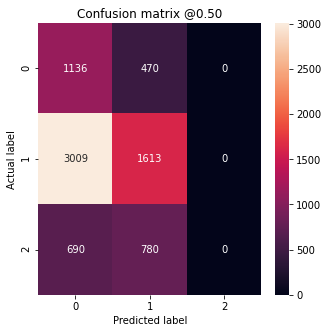

In [24]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

# over sample

In [25]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
train_features_sm, train_labels_sm = oversample.fit_resample(train_features, train_labels)
print(train_features_sm.shape,train_labels_sm.shape)

(44544, 26) (44544,)


In [26]:
os_model = make_model()
os_model.load_weights(initial_weights)
os_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                432       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = os_model.fit(
    train_features_sm,
    train_labels_sm,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
22/22 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - tp: 12654.3478 - fp: 4861.6087 - tn: 4898.0000 - fn: 9726.4783 - accuracy: 0.3601 - precision: 0.7296 - recall: 0.5632 - auc: 0.5154 - prc: 0.7278 - val_loss: 0.0000e+00 - val_tp: 2284.0000 - val_fp: 492.0000 - val_tn: 781.0000 - val_fn: 2601.0000 - val_accuracy: 0.3935 - val_precision: 0.8228 - val_recall: 0.4676 - val_auc: 0.5722 - val_prc: 0.8227
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - tp: 7831.3478 - fp: 3424.1304 - tn: 4716.7391 - fn: 8470.2174 - accuracy: 0.3330 - precision: 0.6971 - recall: 0.4849 - auc: 0.5671 - prc: 0.7378 - val_loss: 0.0000e+00 - val_tp: 1929.0000 - val_fp: 452.0000 - val_tn: 821.0000 - val_fn: 2956.0000 - val_accuracy: 0.3477 - val_precision: 0.8102 - val_recall: 0.3949 - val_auc: 0.5955 - val_prc: 0.8385
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - tp: 6970.4348 - fp: 2864.7826 - tn: 52

In [28]:
train_predictions_os = os_model.predict(train_features_sm, batch_size=BATCH_SIZE)
test_predictions_os = os_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  2188.0
fp :  414.0
tn :  1192.0
fn :  3904.0
accuracy :  0.3406079411506653
precision :  0.8408915996551514
recall :  0.35915955901145935
auc :  0.6111099720001221
prc :  0.8386220932006836



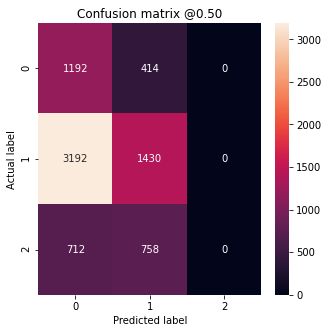

In [29]:
results = os_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(os_model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_os)

#plot_cm(train_labels, train_predictions_baseline)

# Data aug

In [30]:
def mirrorY(raw_data, posenet=False):
    
    try:
        aug_data_y_mirror = raw_data.copy()
        
        if posenet:
            aug_data_y_mirror = aug_data_y_mirror.append(aug_data_y_mirror.assign(head_y=-aug_data_y_mirror['head_y'],
                                                                                  leftShoulder_y=-aug_data_y_mirror['leftShoulder_y'], 
                                                                                  rightShoulder_y=-aug_data_y_mirror['rightShoulder_y'],
                                                                                  leftElbow_y=-aug_data_y_mirror['leftElbow_y'],
                                                                                  rightElbow_y=-aug_data_y_mirror['rightElbow_y'],
                                                                                  leftWrist_y=-aug_data_y_mirror['leftWrist_y'],
                                                                                  rightWrist_y=-aug_data_y_mirror['rightWrist_y'],
                                                                                  leftHip_y=-aug_data_y_mirror['leftHip_y'],
                                                                                  rightHip_y=-aug_data_y_mirror['rightHip_y'],
                                                                                  leftKnee_y=-aug_data_y_mirror['leftKnee_y'],
                                                                                  rightKnee_y=-aug_data_y_mirror['rightKnee_y'],
                                                                                  leftAnkle_y=-aug_data_y_mirror['leftAnkle_y'],
                                                                                  rightAnkle_y=-aug_data_y_mirror['rightAnkle_y']))
        else:
            aug_data_y_mirror = aug_data_y_mirror.append(aug_data_y_mirror.assign(head_y=-aug_data_y_mirror['head_y'],
                                                                                  left_shoulder_y=-aug_data_y_mirror['left_shoulder_y'], 
                                                                                  left_elbow_y=-aug_data_y_mirror['left_elbow_y'],
                                                                                  right_shoulder_y=-aug_data_y_mirror['right_shoulder_y'],
                                                                                  right_elbow_y=-aug_data_y_mirror['right_elbow_y'],
                                                                                  left_hand_y=-aug_data_y_mirror['left_hand_y'],
                                                                                  right_hand_y=-aug_data_y_mirror['right_hand_y'],
                                                                                  left_hip_y=-aug_data_y_mirror['left_hip_y'],
                                                                                  right_hip_y=-aug_data_y_mirror['right_hip_y'],
                                                                                  left_knee_y=-aug_data_y_mirror['left_knee_y'],
                                                                                  right_knee_y=-aug_data_y_mirror['right_knee_y'],
                                                                                  left_foot_y=-aug_data_y_mirror['left_foot_y'],
                                                                                  right_foot_y=-aug_data_y_mirror['right_foot_y']))
        
        
        #print(raw_data.shape)
        #print(aug_data_y_mirror.shape)
        return aug_data_y_mirror
    
    except IOError as e:
        print(e)
        return None

In [31]:
def augMultiplier(raw_data, multiplier):
    
    try:
        aug_data_offset = raw_data.copy()
        #print(aug_data_offset.head())
        aug_data_offset *= multiplier
        #print(aug_data_offset.head())
        return aug_data_y_mirror
    
    except IOError as e:
        print(e)
        return None

In [32]:
aug_data_y_mirror = mirrorY(raw_data, True)

In [33]:
aug_data_offset = augMultiplier(raw_data, multiplier=2)

In [34]:
aug_data_offset = augMultiplier(raw_data, multiplier=0.5)